# Import libraries

In [2]:
import os
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model, layers
import tensorflow as tf 
import keras

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

c:\Users\619ar\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Viewing images

In [3]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
        if len(images) > 3:
            break
    fig = plt.figure(figsize=(10,12))
    xrange = range(1,5)

    for img, x in zip(images, xrange):
        ax = fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

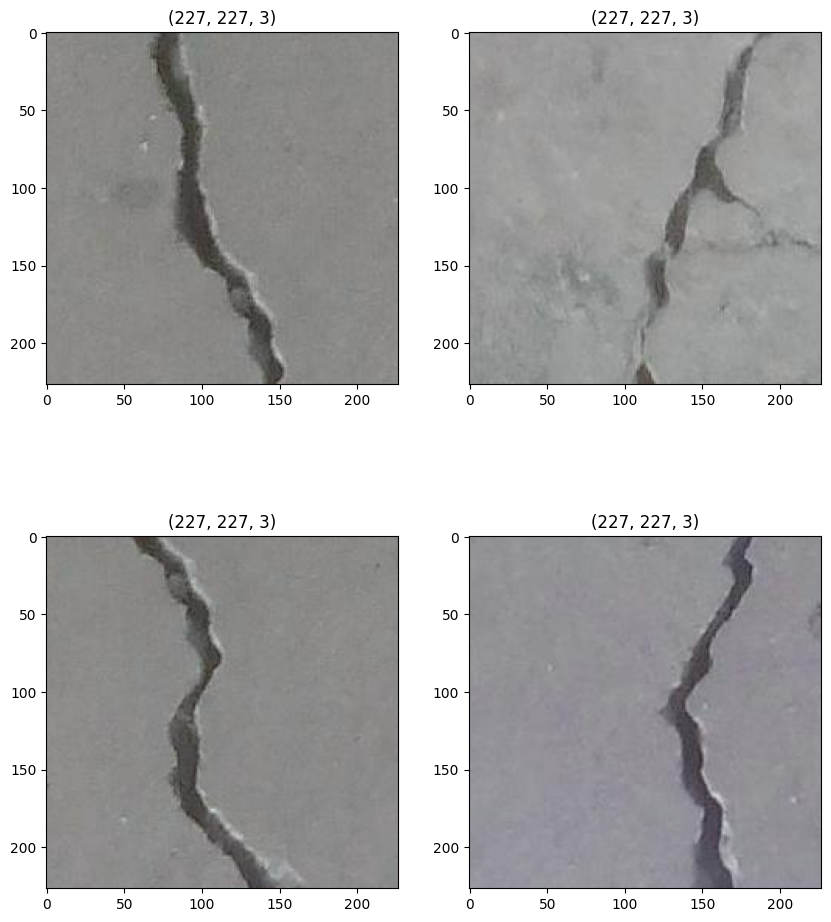

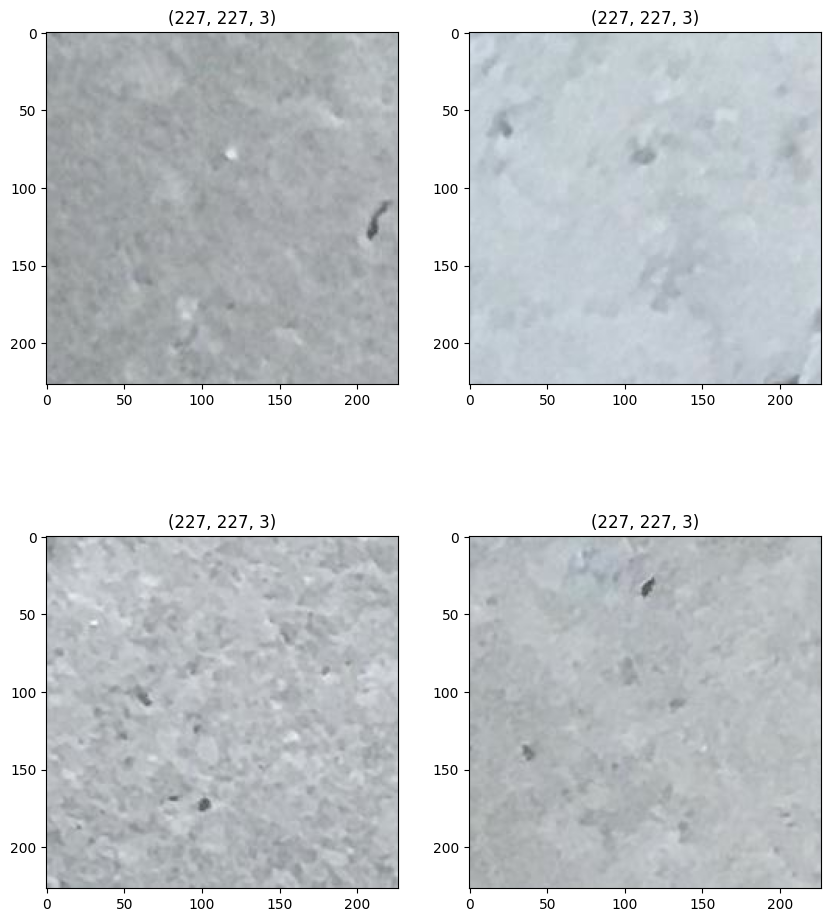

In [4]:
load_images('data/Positive')
load_images('data/Negative')

# Deleting duplicates if any

In [5]:
from PIL import Image
import hashlib

def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def delete_duplicate_images(folder):
    image_hashes = set()
    duplicate_images = 0

    for filename in os.listdir(folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(folder, filename)
            image_hash = get_image_hash(file_path)

            if image_hash in image_hashes:
                os.remove(file_path)
                duplicate_images += 1

            else:
                image_hashes.add(image_hash)

    return duplicate_images

total_files = count_files_in_directory('data/Positive')
print(f'Total number of Positive files: {total_files}')
duplicates = delete_duplicate_images('data/Positive')
print(f'Number of Positive duplicate images deleted: {duplicates}')

total_files = count_files_in_directory('data/Negative')
print(f'Total number of Negative files: {total_files}')
duplicates = delete_duplicate_images('data/Negative')
print(f'Number of Negative duplicate images deleted: {duplicates}')

Total number of Positive files: 20000
Number of Positive duplicate images deleted: 316
Total number of Negative files: 20000
Number of Negative duplicate images deleted: 1282


In [6]:
total_files = count_files_in_directory('data/Positive')
print(f'Total number of Positive files: {total_files}')
total_files = count_files_in_directory('data/Negative')
print(f'Total number of Negative files: {total_files}')

Total number of Positive files: 19684
Total number of Negative files: 18718


# Callback class to stop training at > 99.9% accuracy

In [7]:
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.999:
            print('\n Reached 99.9% accuracy so ending training')
            self.model.stop_training = True

# Setting up pretrained InceptionV3

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

# Make all layers in pretrained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normaliza

# Choosing cut-off point and adding custom layers

In [9]:
# We will test with 3 cut-off points: 'mixed7', 'mixed5b', 'avg_pool'
# model1: cut-off at 'mixed7'
# model2: cut-off at 'mixed5b'
# model3: cut-off at 'avg_pool'

cut_off_layers = ['average_pooling2d', 'mixed5', 'mixed7']
models = []

for cut_off_layer in cut_off_layers:
    last_layer = pre_trained_model.get_layer(cut_off_layer)
    last_output = last_layer.output
    # Now adding custom layers

    # Flatten output to 1D
    x = layers.Flatten()(last_output)

    # Add fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)

    # Add dropout layer
    x = layers.Dropout(0.2)(x)

    # Sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(pre_trained_model.input, x)

    model.compile(
        optimizer = RMSprop(learning_rate = 0.0001),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    models.append(model)


# Training and Validation Data

In [10]:
# Create DataGenerator
# Use 0.3 as split

train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    'data',
    target_size = (150, 150),
    batch_size = 64,
    shuffle = True,
    class_mode = 'binary',
    subset = 'training'
)

Found 26882 images belonging to 2 classes.


In [11]:
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)
val_generator = val_datagen.flow_from_directory(
    'data',
    target_size = (150, 150),
    batch_size = 64,
    class_mode = 'binary',
    subset = 'validation'
)

Found 11520 images belonging to 2 classes.


# Training

In [12]:
callbacks = myCallBack()

accs = []
val_accs = []
losses = []
val_losses = []

for model in models:
    history = model.fit_generator(
        train_generator,
        validation_data = val_generator,
        epochs = 10,
        verbose = True,
        callbacks = [callbacks]
    )

    accs.append(history.history['accuracy'])
    val_accs.append(history.history['val_accuracy'])
    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

Epoch 1/10



C:\Users\619ar\AppData\Local\Temp\ipykernel_34924\3684909266.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(



421/421 [==============================] - 102s 240ms/step - loss: 0.7121 - accuracy: 0.8255 - val_loss: 0.1564 - val_accuracy: 0.9508
Epoch 2/10
421/421 [==============================] - 102s 242ms/step - loss: 0.1519 - accuracy: 0.9480 - val_loss: 0.0883 - val_accuracy: 0.9718
Epoch 3/10
421/421 [==============================] - 102s 242ms/step - loss: 0.1106 - accuracy: 0.9618 - val_loss: 0.1265 - val_accuracy: 0.9539
Epoch 4/10
421/421 [==============================] - 102s 241ms/step - loss: 0.0907 - accuracy: 0.9693 - val_loss: 0.0419 - val_accuracy: 0.9872
Epoch 5/10
421/421 [==============================] - 102s 242ms/step - loss: 0.0794 - accuracy: 0.9737 - val_loss: 0.0715 - val_accuracy: 0.9759
Epoch 6/10
421/421 [==============================] - 102s 243ms/step - loss: 0.0716 - accuracy: 0.9769 - val_loss: 0.0487 - val_accuracy: 0.9830
Epoch 7/10
421/421 [==============================] - 100s 237ms/step - loss: 0.0663 - accuracy: 0.9789 - val_loss: 0.0338 - val_accur

# Results

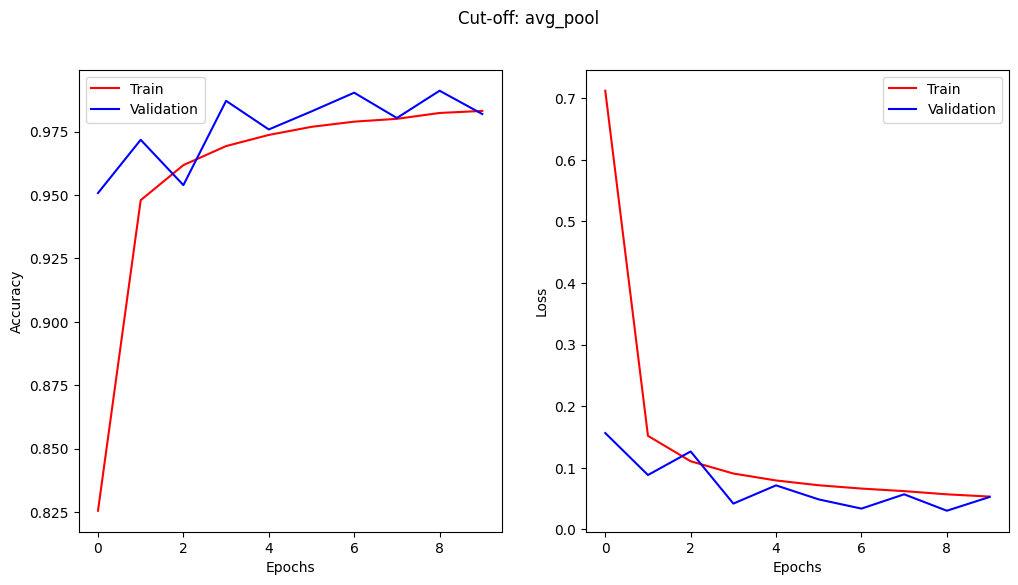

In [21]:
acc = accs[0]
val_acc = val_accs[0]
loss = losses[0]
val_loss = val_losses[0]

epochs = range(len(acc))

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].plot(epochs, acc, 'r', label='Train')
axes[0].plot(epochs, val_acc, 'b', label = 'Validation')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'r', label='Train')
axes[1].plot(epochs, val_loss, 'b', label = 'Validation')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.suptitle('Cut-off: avg_pool')
plt.tight_layout
plt.show()

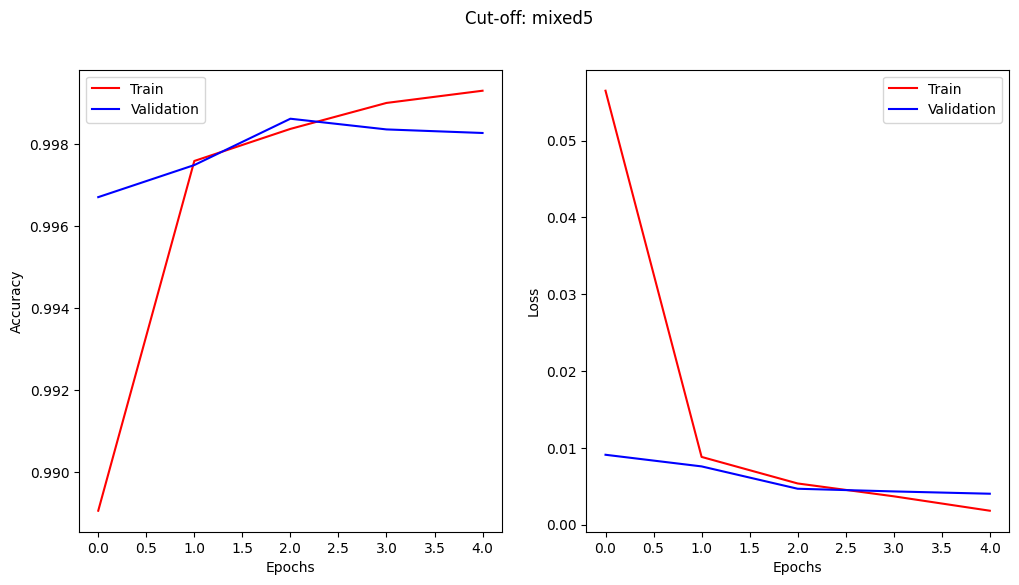

In [22]:
acc = accs[1]
val_acc = val_accs[1]
loss = losses[1]
val_loss = val_losses[1]

epochs = range(len(acc))

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].plot(epochs, acc, 'r', label='Train')
axes[0].plot(epochs, val_acc, 'b', label = 'Validation')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'r', label='Train')
axes[1].plot(epochs, val_loss, 'b', label = 'Validation')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.suptitle('Cut-off: mixed5')
plt.tight_layout
plt.show()

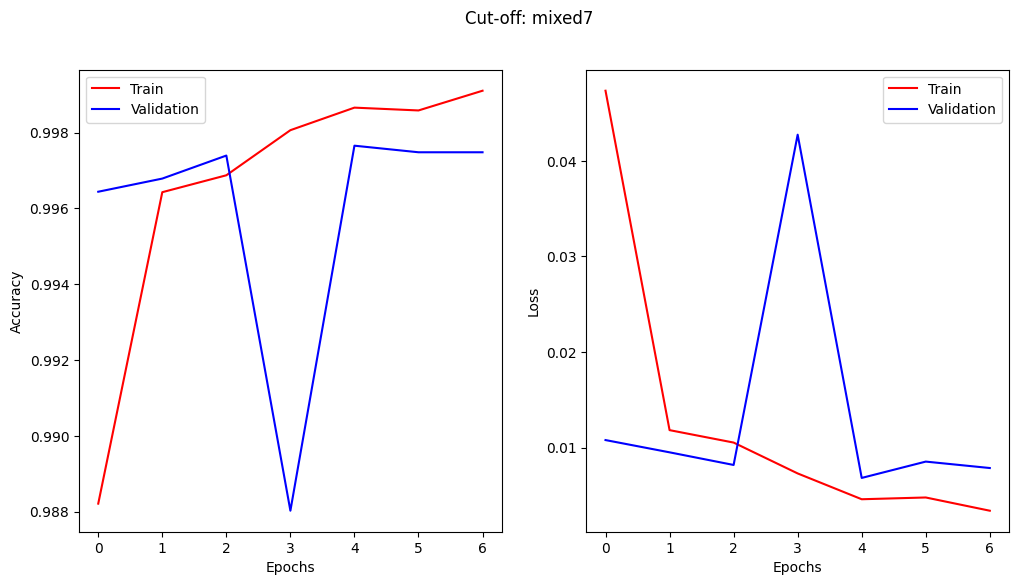

In [23]:
acc = accs[2]
val_acc = val_accs[2]
loss = losses[2]
val_loss = val_losses[2]

epochs = range(len(acc))

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].plot(epochs, acc, 'r', label='Train')
axes[0].plot(epochs, val_acc, 'b', label = 'Validation')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'r', label='Train')
axes[1].plot(epochs, val_loss, 'b', label = 'Validation')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.suptitle('Cut-off: mixed7')
plt.tight_layout
plt.show()

In [24]:
models[0].save('Crack_Detection_InceptionV3_model1.h5')
models[1].save('Crack_Detection_InceptionV3_model2.h5')
models[2].save('Crack_Detection_InceptionV3_model3.h5')

c:\Users\619ar\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


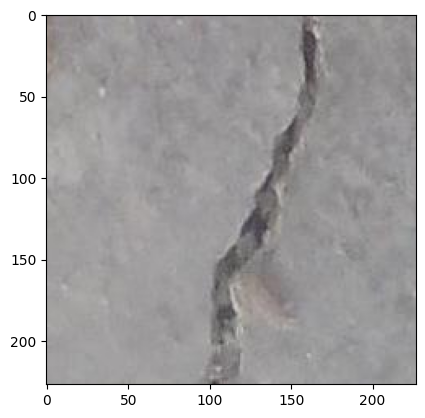

1/1 [==============================] - 1s 839ms/step
Model probability for crack existance: [0.99999964]


In [25]:
from keras.models import load_model

model = load_model('Crack_Detection_InceptionV3_model2.h5')

img_path = r'data\Positive\00010.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


img = cv2.resize(img, (150,150))

img = img/255.0
img = np.expand_dims(img, axis = 0)

pred = model.predict(img)
print(f"Model probability for crack existance: {pred[0]}")